In [1]:
import gym
import torch
import torch.optim as optim
from itertools import count
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib
from matplotlib import pyplot as plt

In [2]:
class Critic(nn.Module):
  def __init__(self, d_in):
    super(Critic, self).__init__()
    self.lin1 = nn.Linear(d_in, 32)
    self.lin2 = nn.Linear(32, 1)

  def forward(self, x):
    x = x.double()
    x = F.relu(self.lin1(x))
    return self.lin2(x)

class Actor(nn.Module):
  def __init__(self, d_in, d_out):
    super(Actor, self).__init__()
    self.lin1 = nn.Linear(d_in, 32)
    self.lin2 = nn.Linear(32, d_out)
    self.soft = nn.Softmax(dim=0)

  def forward(self, x):
    x = x.double()
    x = F.relu(self.lin1(x))
    return self.soft(self.lin2(x))

In [3]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# plt.ion()

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Episode Duration')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    # Take 50 episode averages and plot them too
    if len(durations_t) >= 50:
        means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy(),label='50-episode mean')
        plt.legend()
    plt.show()

    plt.figure(1)
    plt.clf()
    actor_loss = torch.tensor(actor_loss_log, dtype=torch.float)
    plt.title('Actor Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(actor_loss.numpy())

    if len(actor_loss) >= 50:
        means = actor_loss.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy(),label='50-episode mean')
        plt.legend()
    plt.show()

    plt.figure(1)
    plt.clf()
    critic_loss = torch.tensor(critic_loss_log, dtype=torch.float)
    plt.title('Critic Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.plot(critic_loss.numpy())

    if len(critic_loss) >= 50:
        means = critic_loss.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy(),label='50-episode mean')
        plt.legend()
    plt.show()
    
    # LIVE PLOTTING
    # if is_ipython:
    #     display.clear_output(wait=True)
    #     display.display(plt.gcf())

In [4]:
### HYPERPARAMETERS ###

env = gym.make('CartPole-v0')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using " + str(device))
episode_durations = []
actor_loss_log = []
critic_loss_log = []
action_conf_log = []

n_actions = env.action_space.n
n_state = env.observation_space.shape[0]-2

# actions:{0,1} apply force {+1 move right, -1 move left}
# Actor represents policy, given a state provide the probability of taking each action
actor = Actor(d_in=n_state, d_out=n_actions).double().to(device)

# Critic represents value function, given a state return the estimated value
critic = Critic(d_in=n_state).double().to(device)

# reward discount factor
gamma = 0.99
n_episodes = 500
lr_actor = .001
lr_critic = .005

optimizer_actor = optim.Adam(actor.parameters(),lr=lr_actor)
optimizer_critic = optim.Adam(critic.parameters(),lr=lr_critic)
criterion_actor = nn.CrossEntropyLoss()
criterion_critic = nn.MSELoss()

using cuda


Complete


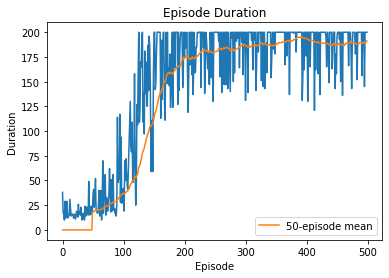

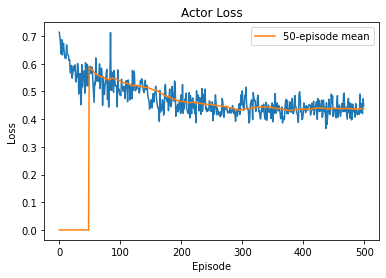

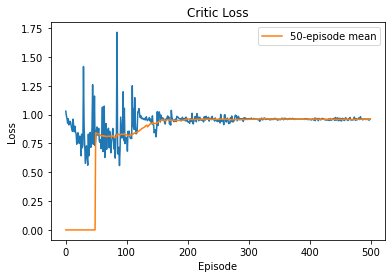

In [5]:
for index, episode in enumerate(range(n_episodes)):
  state = env.reset()
  # only last two state observations are needed: angle and angular velocity
  state = torch.DoubleTensor(state)[-2:].to(device)

  if (index+1) % 200 == 0:
    lr_actor *= .1
    optimizer_actor = optim.Adam(actor.parameters(),lr=lr_actor)

  # log progress
  acc_loss_actor = 0.0
  acc_loss_critic = 0.0

  action = actor(state)

  for t in count():    
    # choose action stochastically
    step_action = np.random.choice(n_actions,p=action.detach().cpu().numpy())
    state_prime, reward, done, info = env.step(step_action)
    done_mask = 0. if done else 1.

    done_mask = torch.as_tensor(done_mask).requires_grad_().to(device)
    reward = torch.as_tensor(reward).requires_grad_().to(device)
    state_prime = torch.tensor(state_prime[-2:], requires_grad=True).to(device)

    # state-value V is expectation of return
    value = critic(state.detach())
    value_prime = critic(state_prime.detach())

    ### UPDATE ACTOR ###
    optimizer_actor.zero_grad()
    
    # update actor in direction of higher value (or quality)
    quality = reward + gamma*value_prime*done_mask # definition of Q(s,a)

    g_prime = quality - value # update expected return G of the action taken 
    advantage = g_prime
    
    target = torch.tensor([step_action])
    log_prob = torch.log(action)[target]
    
    # update actor's policy in direction of increasing advantage
    actor_loss = -(log_prob * advantage.detach()).mean()
    actor_loss.backward(retain_graph=True)
    optimizer_actor.step()

    ### UPDATE CRITIC ###

    optimizer_critic.zero_grad()
    
    # weigh the predicted value of our state against the added/lossed value when we took action a
    critic_loss = criterion_critic(value, quality)
    critic_loss.backward(retain_graph=True)
    optimizer_critic.step()

    acc_loss_actor += actor_loss.detach().cpu()
    acc_loss_critic += critic_loss.detach().cpu()
    action_prime = actor(state_prime)
    action = action_prime
    state = state_prime

    if done:
      episode_durations.append(t+1)
      actor_loss_log.append(acc_loss_actor/(t+1))
      critic_loss_log.append(acc_loss_critic/(t+1))
      
      # LIVE PLOTTING
      # plot_durations()
      break

print('Complete')
env.close()
plot_durations()
# plt.ioff() # live plotting